In [88]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
#from pandas.core import datetools
from pandas import DataFrame
from statsmodels.tsa.arima_model import ARIMA
from matplotlib import pyplot

In [89]:
atmdata = pd.read_csv('D:\\PYTHONDATA\\ATMData\\ATM.csv',header=0,parse_dates=[1]                      )

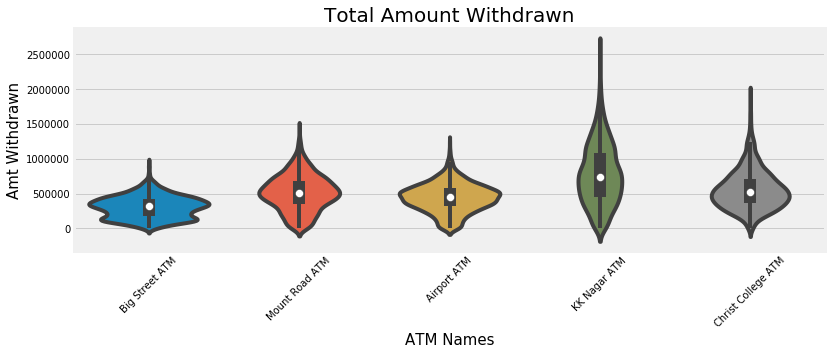

In [90]:
plt.figure(figsize = (12,14))
plt.subplot(313)
g2 = sns.violinplot(x="atm_name", y="total_amount_withdrawn", data=atmdata)
g2.set_xticklabels(g2.get_xticklabels(),rotation=45)
g2.set_xlabel("ATM Names", fontsize=15)
g2.set_ylabel("Amt Withdrawn", fontsize=15)
g2.set_title("Total Amount Withdrawn", fontsize=20)

#plt.subplots_adjust(wspace = 0.2, hspace = 0.7,top = 0.9)

plt.show()

In [91]:
AirportATM  = atmdata.query('atm_name=="Airport ATM"')
BigstreetATM  = atmdata.query('atm_name=="Big Street ATM"')
chirstCollegeATM  = atmdata.query('atm_name=="Christ College ATM"')

2011-01-01    503400
2011-01-02    268600
2011-01-03    603900
2011-01-04    541600
2011-01-05    530000
dtype: int64


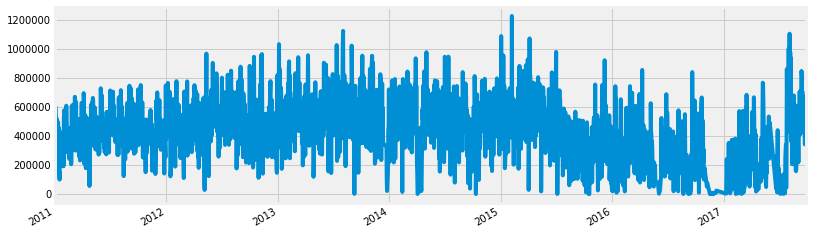

In [92]:
# Lets Anlyse only AIRPORT ATM Data
series = pd.Series( AirportATM['total_amount_withdrawn'].values, AirportATM['transaction_date'].values)
print(series.head())
series.plot(figsize=(12,4))

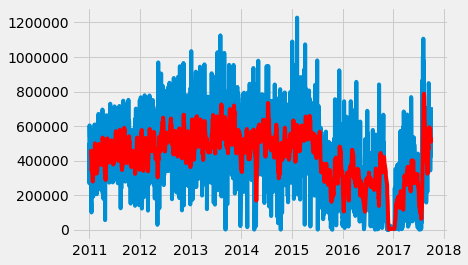

In [120]:
# moving Average
ts_log = np.log(series)
moving_avg = pd.rolling_mean(series,12)
plt.plot(series)
plt.plot(moving_avg, color='red')

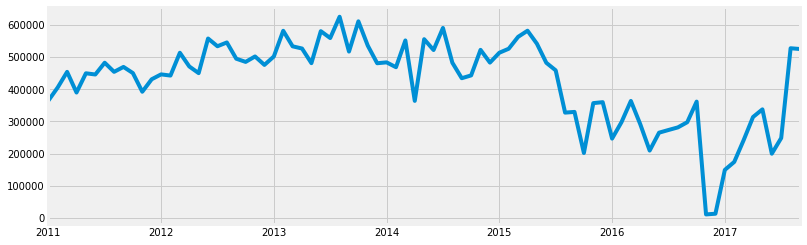

In [94]:
y = series.resample('MS').mean()
y.plot(figsize=(12, 4))


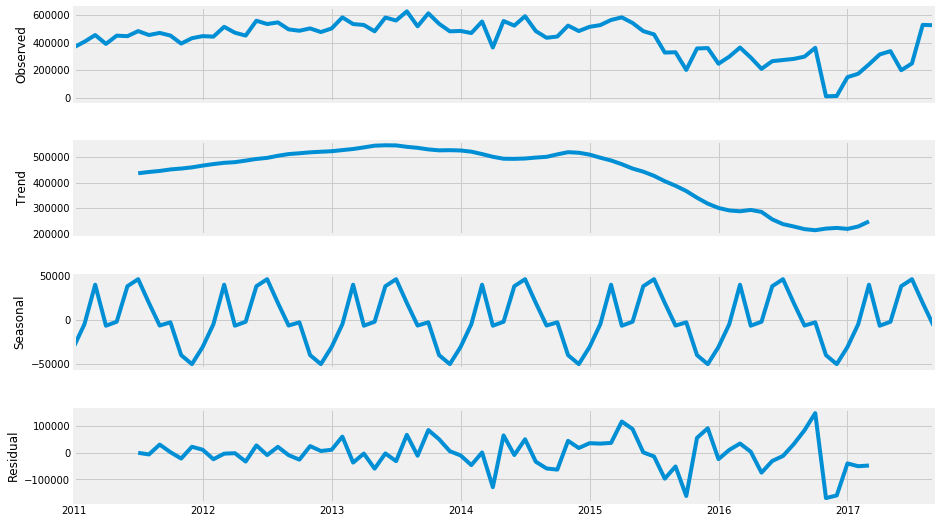

In [95]:
from statsmodels.tsa.stattools import acf  
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(y, freq=12)  
fig = plt.figure()  
fig = decomposition.plot()  
fig.set_size_inches(15, 8)

In [96]:
from statsmodels.tsa.stattools import adfuller

def test_stationarity(timeseries):

    #Determing rolling statistics
   #rolmean = pd.rolling_mean(timeseries, window=12)
   # rolstd = pd.rolling_std(timeseries, window=12)
   
    rolmean = timeseries.rolling(window=3).mean()
    rolstd =  timeseries.rolling(window=3).std()
    
    #Plot rolling statistics:
    fig = plt.figure(figsize=(12, 8))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
        #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    

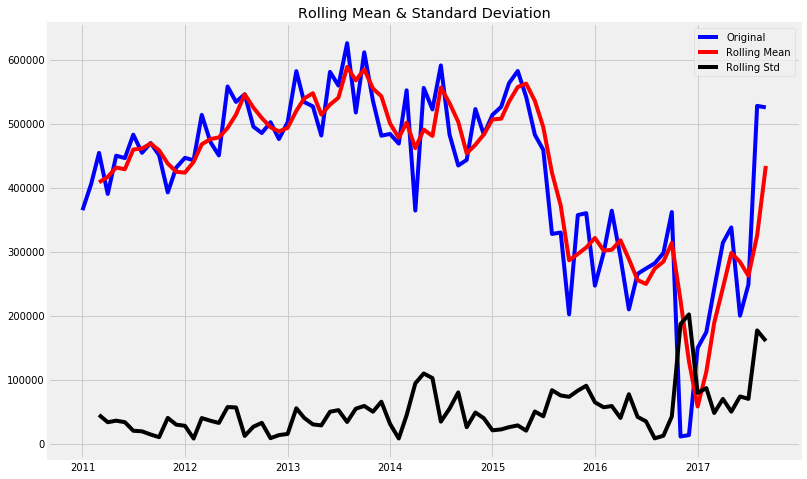

Results of Dickey-Fuller Test:
Test Statistic                 -2.950113
p-value                         0.039823
#Lags Used                      0.000000
Number of Observations Used    80.000000
Critical Value (1%)            -3.514869
Critical Value (5%)            -2.898409
Critical Value (10%)           -2.586439
dtype: float64


In [97]:
import warnings
test_stationarity(y)

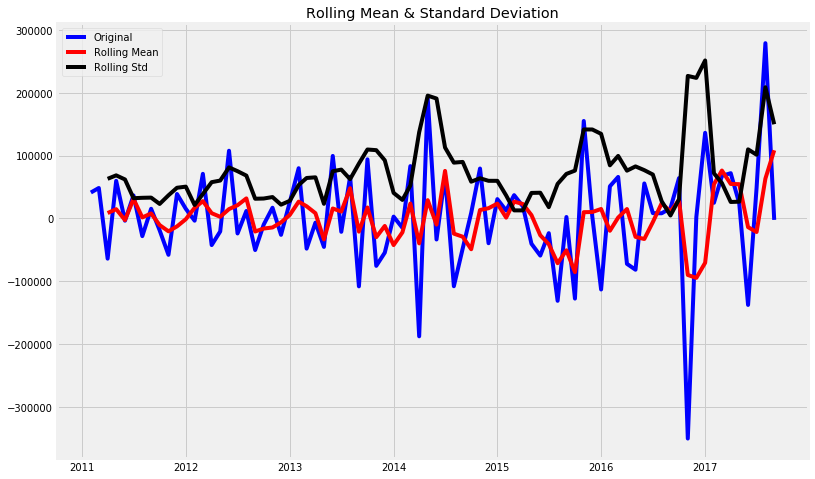

Results of Dickey-Fuller Test:
Test Statistic                -6.494106e+00
p-value                        1.206256e-08
#Lags Used                     2.000000e+00
Number of Observations Used    7.700000e+01
Critical Value (1%)           -3.518281e+00
Critical Value (5%)           -2.899878e+00
Critical Value (10%)          -2.587223e+00
dtype: float64


In [98]:
y['first_difference'] = y - y.shift(1)  
test_stationarity(y.first_difference.dropna(inplace=False))

In [99]:
import warnings
import itertools
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [100]:
import statsmodels.api as sm
import matplotlib.pyplot as plt
from pandas.core import datetools
plt.style.use('fivethirtyeight')

In [105]:
best_aic = np.inf
best_pdq = None
best_seasonal_pdq = None
tmp_model = None
best_mdl = None

In [106]:
y = series.resample('MS').mean()
warnings.filterwarnings("ignore") # specify to ignore warning messages

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()
            if res.aic < best_aic:
                best_aic = res.aic
                best_pdq = param
                best_seasonal_pdq = param_seasonal
                best_mdl = tmp_mdl

            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue
print("Best SARIMAX{}x{}12 model - AIC:{}".format(best_pdq, best_seasonal_pdq, best_aic))

ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:1500.6989689076063
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:1826.9242803927339
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:1799.2382159490487
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:1522.6302391225531
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:1500.35816072725
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:2230.1102930616344
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:1883.2657098070601
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:1763.780546836526
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:1456.4753180121563
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:1931.8817411166979
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:1878.0974538612684
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:1508.5773798423556
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:1455.2460586468408
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:1722.4440671296225
ARIMA(0, 1, 0)x(0, 1, 1, 12)12 - AIC:1442.0850780895566
ARIMA(0, 1, 0)x(1, 0, 0, 12)12 - AIC:1744.9075197638101
ARIMA(0, 1, 0)x(1, 0, 1, 12)12 - AIC:1722.23477781805
ARIMA(0, 1, 0)x(1, 1, 0, 12)12 - AIC:1473.26607372464

In [107]:
#The output of our code suggests that SARIMAX(1, 1, 1)x(1, 1, 1, 12) yields the lowest AIC value of 1410. 
# define SARIMAX model and fit it to the data
mdl = sm.tsa.statespace.SARIMAX(y,
                                order=(1,1,1),
                                seasonal_order=(1,1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
res = mdl.fit()


In [108]:
 # print statistics
print(res.aic)
print(res.summary())

1410.8808006
                                 Statespace Model Results                                 
Dep. Variable:                                  y   No. Observations:                   81
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -700.440
Date:                            Sat, 04 Aug 2018   AIC                           1410.881
Time:                                    23:59:15   BIC                           1422.853
Sample:                                01-01-2011   HQIC                          1415.684
                                     - 09-01-2017                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2124      0.617      0.344      0.731      -0.998       1.422
ma.L1         -0.4945 

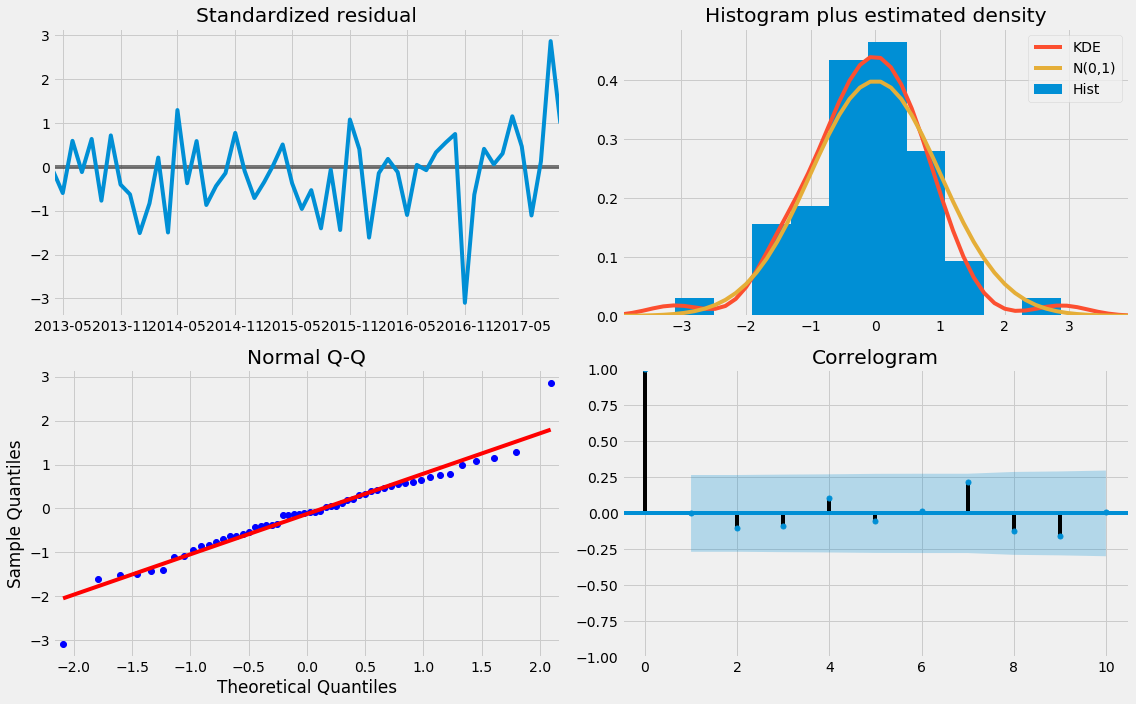

In [109]:
# run model diagnostics to ensure that none of the assumptions made by the model have been violated
res.plot_diagnostics(figsize=(16, 10))
plt.tight_layout()
plt.show()

In [110]:
pred = res.get_prediction(start=pd.to_datetime('2016-01-01'), dynamic=False, full_results=True)
pred_ci = pred.conf_int()
pred_ci

,lower y,upper y
2016-01-01,207957.855083,644795.430705
2016-02-01,95385.732734,532223.780986
2016-03-01,125060.775823,561897.695783
2016-04-01,86163.764360,523000.408488
2016-05-01,113422.994258,550259.570954
2016-06-01,41658.533315,478495.093525
2016-07-01,63377.224798,500213.780979
2016-08-01,26167.513677,463004.068873
2016-09-01,17482.164848,454318.719802
2016-10-01,59745.771212,496582.326108


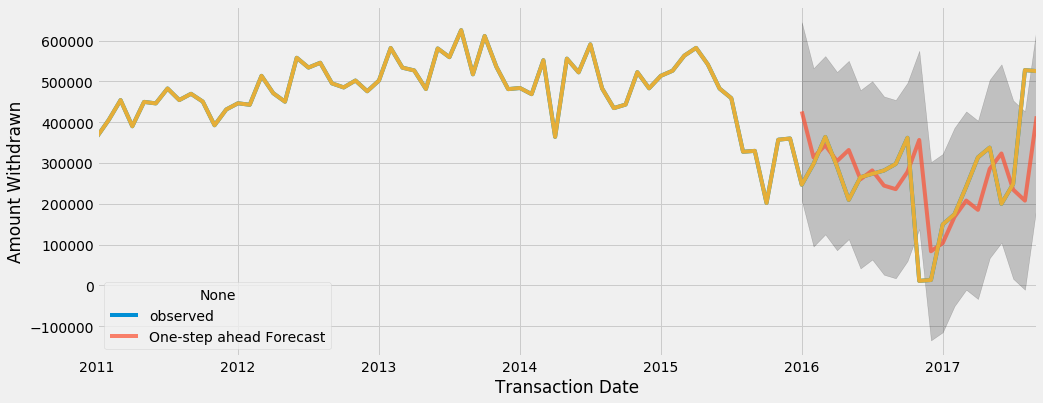

In [111]:
figsize=(16, 10)
ax = y['2011-01-01':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7)
#pred.plot(ax=ax, label='One-step ahead Forecast', alpha=.7)
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Transaction Date')
ax.set_ylabel('Amount Withdrawn')
plt.legend()
y.plot(figsize=(15, 6))
plt.show()

In [112]:
y_forecasted = pred.predicted_mean
y_truth = y['2016-01-01':]

# Compute the mean square error
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 16049870248.34


In [113]:
# Get forecast 25 steps ahead in future
pred_uc = results.get_forecast(steps=25)
# Get confidence intervals of forecasts
pred_ci = pred_uc.conf_int()


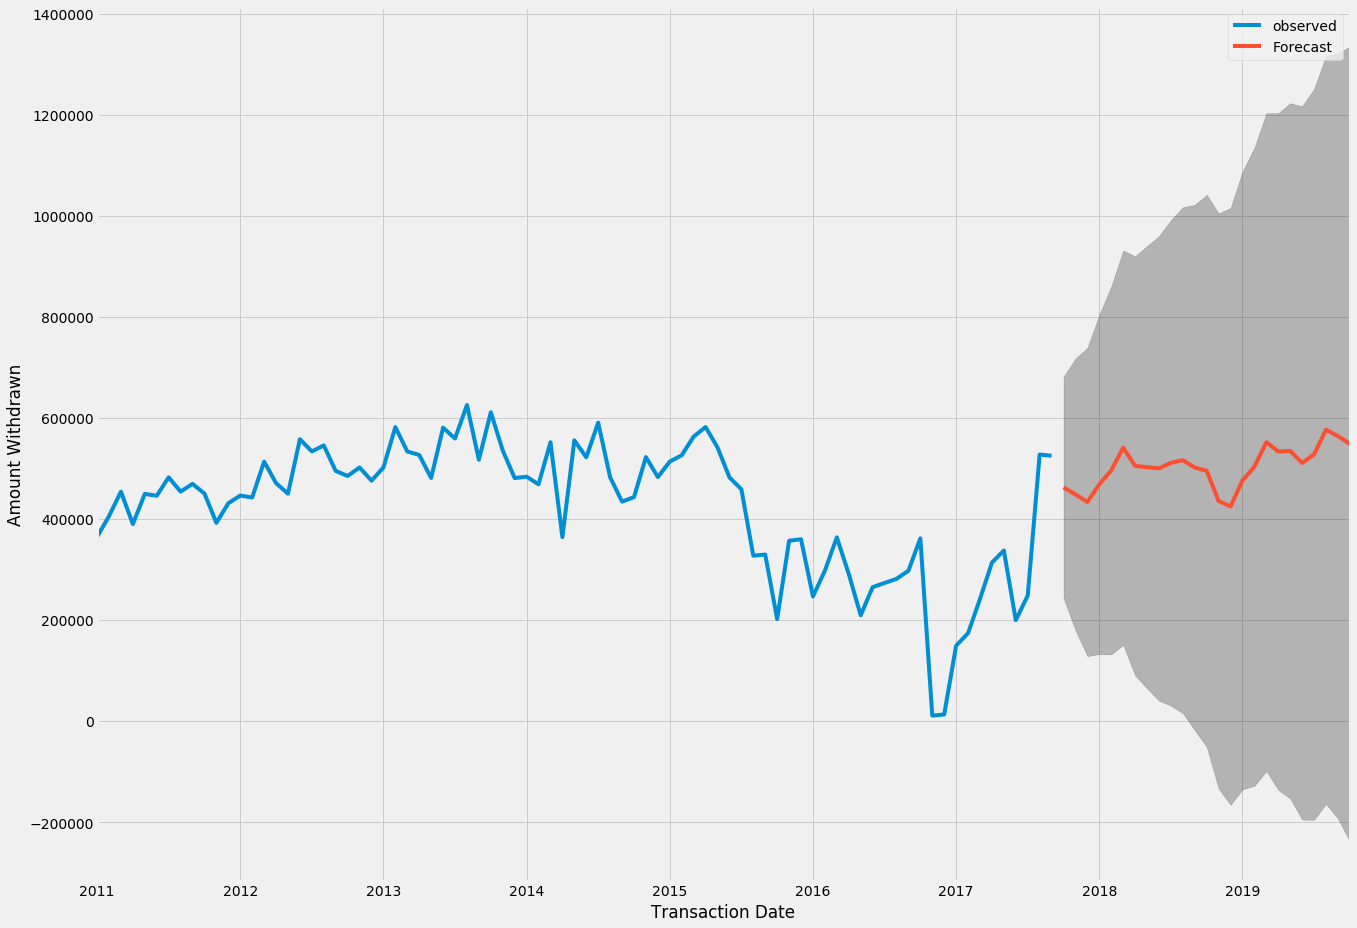

In [115]:
ax = y.plot(label='observed', figsize=(20, 15))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,  pred_ci.iloc[:, 0],  pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Transaction Date')
ax.set_ylabel('Amount Withdrawn')

plt.legend()
plt.show()
